In [ ]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

In [ ]:
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import math

import yfinance as yahooFinance
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split

In [ ]:
#den wievielten Tag er vorhersagen soll
forecastDays = 365

# wie viele Tage das Modell shiftet für die Vorhersage (in wie viel Tagen steigen oder fallen)
shifter = 30

#wie viele Tage warten, bis Entscheidung geändert werden kann?
delay = 5

# Wie viele Tage davor in eine Zeile!
lag_steps = 30

In [ ]:
ETH = yahooFinance.Ticker("ETH-USD").history(period='max')

In [ ]:
#Plotting our Signals on our time period
def plotBuySell(testETH):
  plt.figure(figsize=(16,8))
  plt.scatter(testETH.index, testETH["Buy"], color = "green", label = "Buy", marker = "^", alpha=1)
  plt.scatter(testETH.index, testETH["Sell"], color = "red", label = "Sell", marker = "v", alpha=1)
  plt.plot(testETH.index, testETH["Close"], alpha = 0.5)
  plt.show()

def createBuySell(testETH):
  buysell = buy_sell(testETH, delay)
  testETH["Buy"] = buysell[0]
  testETH["Sell"] = buysell[1]
  #Replacing the first Sell signal by a NaN value
  testETH["Sell"][0] = np.nan
  plotBuySell(testETH)
  return testETH

def performance(data):
    performance = [100]
    num_stocks = 0
    for i in range(len(data)):
        if math.isnan(data["Buy"][i]) == False:
            num_stocks = performance[i]/data["Close"][i]
            performance.append(num_stocks*data["Close"][i])
        elif math.isnan(data["Sell"][i]) == False:
            cash = num_stocks * data["Close"][i]
            performance.append(cash)
        else:
            performance.append(performance[i])


    plt.figure(figsize= (12.6, 4.6))
    plt.plot(performance)
    return performance

def buy_sell(asset, n):
    BuyPrice = []
    SellPrice = []
    flag = -1
    counter = 0

    for i in range(len(asset)):
        if asset["predictedTrade"][i] == 1 and counter == 0:
            if flag != 1:
                BuyPrice.append(asset["Close"][i])
                SellPrice.append(np.nan)
                flag = 1
            else:
                BuyPrice.append(np.nan)
                SellPrice.append(np.nan)
        elif asset["predictedTrade"][i] == -1 and counter ==0:
            if flag !=0:
                BuyPrice.append(np.nan)
                SellPrice.append(asset["Close"][i])
                flag = 0
            else:
                BuyPrice.append(np.nan)
                SellPrice.append(np.nan)
        else:
            BuyPrice.append(np.nan)
            SellPrice.append(np.nan)

        counter +=1
        if counter ==n:
            counter = 0

    return (BuyPrice, SellPrice)

def calc(data):
  truePred = sum(1 for i in range(0,len(data)) if data['predictedTrade'][i] == data['realResult'][i])
  falsePred = sum(1 for i in range(0,len(data)) if data['predictedTrade'][i] != data['realResult'][i])
  all = len(data)
  acc = truePred/all

  print("true: ", truePred)
  print("false: ", falsePred)
  print("all: ", all)
  print("Accurracy: ", acc)

def modelTesterBuyOrSell(data):
  calc(data)
  createBuySell(data)

  test_stock_performance = performance(data)
  print(test_stock_performance[-1])

In [ ]:
def calculateIndicator(currency, shifter):
  currency["RSI"] = ta.RSI(currency["Close"], timeperiod = 14)
  currency["ROC"] = ta.ROC(currency["Close"], timeperiod = 10)
  currency["%R"] = ta.WILLR(currency["High"], currency["Low"], currency["Close"], timeperiod = 14)
  currency["OBV"] = ta.OBV(currency["Close"], currency["Volume"])
  currency["MACD"], currency["MACD_SIGNAL"], currency["MACD_HIST"] = ta.MACD(currency["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
  #Wenn der Wert in 5 Tagen höher ist, als heute, dann 1, wenn nicht, dann -1 (da genau gleich sehr unwahrscheinlich ist, gilt dies auch als -1)
  currency["realResult"] = np.where(currency["Close"].shift(-shifter) > currency["Close"], 1, -1)
  currency["realValueInXDays"] = currency["Close"].shift(-shifter)

calculateIndicator(ETH, shifter)


def cleanDF(df):
  df = df.drop("Dividends", axis=1)
  df = df.drop("Stock Splits", axis=1)

# Alle anderen Werte löschen, da Algoritmus eher verwirrt -> wahrscheinlich weil hohe Volatilität zur Berechnung bon %R aber wichtig!
  df = df.drop("High", axis=1)
  df = df.drop("Low", axis=1)
  df = df.drop("Open", axis = 1)

  # VOLUMEN ist echt verwirrend für den Algorithmus. Es gibt auch keine Korrelation zwicshen dem Volumen und dem Wert, da SVM sonst nicht geht, wurde es jetzt entfernt!
  # Und OBV weil von Volumen berechnet
  df = df.drop("Volume", axis = 1)
  df = df.drop("OBV", axis = 1)
  df.dropna(inplace = True)
  return df

ETH = cleanDF(ETH)

In [ ]:
X = np.array(ETH[["Close", "RSI", "ROC", "%R", "MACD","MACD_SIGNAL", "MACD_HIST", "realResult"]])
X = np.array(ETH[["Close"]])
X = np.array(ETH.drop("realValueInXDays", axis = 1))
X = X[:len(ETH)-forecastDays]

y = np.array(ETH['realValueInXDays'])
y = y[:-forecastDays]

#X = np.array(ETH.drop("realResult", axis = 1))
#X = X[:len(ETH)-forecastDays]

#y = np.array(ETH['realResult'])
#y = y[:-forecastDays]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)
featureNames_X = ETH.drop("realValueInXDays", axis = 1).columns

days = -1*forecastDays
train_ETH, test_ETH = ETH[0:days], ETH[days:]


In [ ]:
modelSVR = SVR(kernel="rbf", C=1e3, gamma=0.00001)
modelSVR.fit(X_train, y_train)
print(f'The accuracy score of the model is {modelSVR.score(X_test, y_test):.4f}')

The accuracy score of the model is 0.9229


true:  221
false:  144
all:  365
Accurracy:  0.6054794520547945


X has feature names, but SVR was fitted without feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

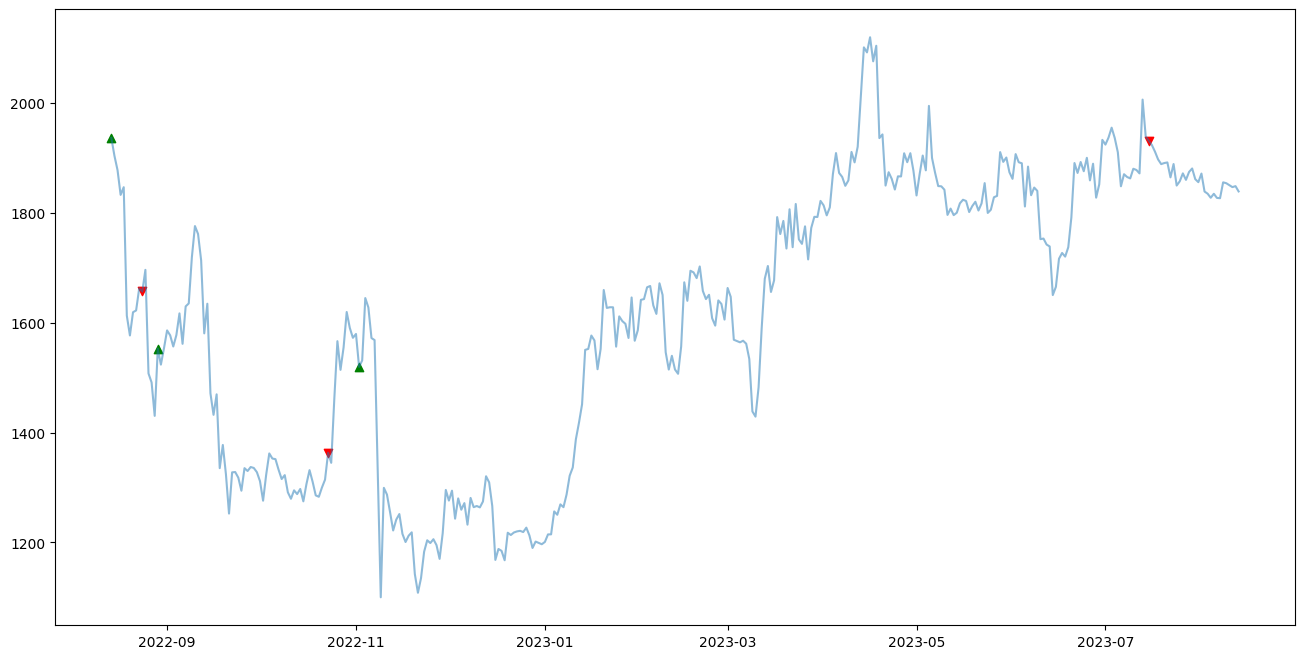

95.46301017897144


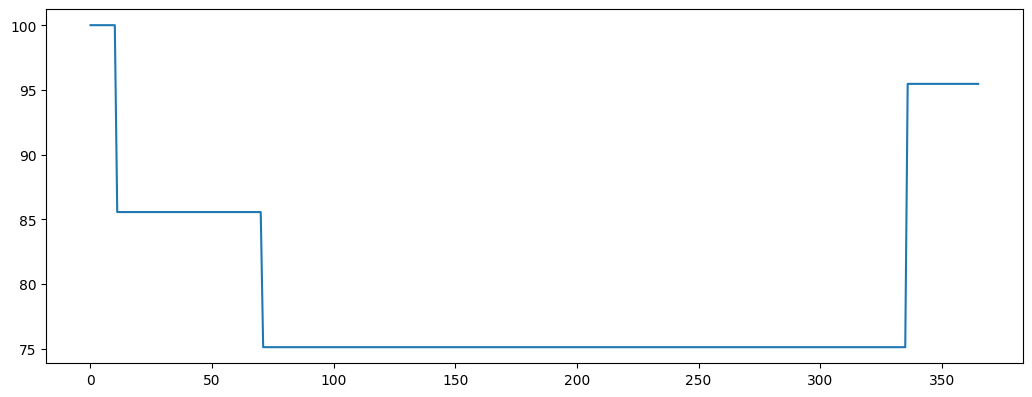

In [ ]:
finalData = test_ETH
finalData['predicted'] = modelSVR.predict(test_ETH.drop('realValueInXDays', axis=1))
finalData['predictedTrade'] = np.where(test_ETH["predicted"].shift(-shifter) > test_ETH["Close"], 1, -1)

modelTesterBuyOrSell(test_ETH)

In [ ]:
print(finalData['predicted'])
print(finalData['realValueInXDays'])

**XAI ab hier**

1. LIME
2. SHAP

In [ ]:
#!pip install interpret
from interpret.blackbox import LimeTabular
from interpret import show

def LimeFunction(mlMethod, X_train_data, X_test_data, y_test_data):
    lime2 = LimeTabular(mlMethod, X_train_data, feature_names = featureNames_X)
    lime_local = lime2.explain_local(X_test_data[-20:],y_test_data[-20:], name='LIME')
    show(lime_local)

In [ ]:
# input (Model, X_train, X_test, y_test)
LimeFunction(modelSVR, X_train, X_test, y_test)

In [ ]:
#!pip install shap
import shap

Exact explainer: 343it [10:13,  1.81s/it]


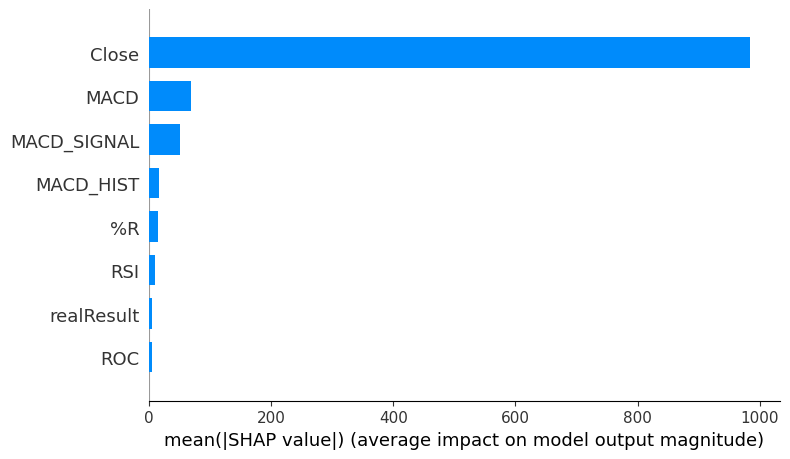

In [ ]:
f = lambda x: modelSVR.predict(x)
shapExplainer = shap.Explainer(f, X_train)
shap_values = shapExplainer(X_test)
shapExplainer = shap.summary_plot(shap_values, X_train, feature_names=featureNames_X, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


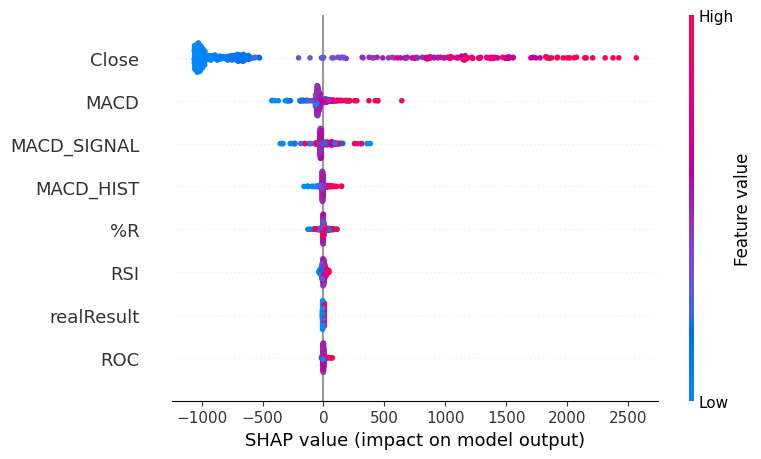

In [ ]:
shap.summary_plot(shap_values,X_test,feature_names=featureNames_X)

In [ ]:
shap.initjs()
shap.force_plot(shapExplainer.expected_value, shap_values[0,:]  ,X_test[0,:],feature_names=featureNames_X)